In [1]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

In [2]:
df=pd.read_csv("forestfires.csv")

In [3]:
print("************************ Exploratory Data Analysis ************************\n\n")
print("------------------ Displaying head ------------------\n")
display(df.head())
print("\n------------------ Dimensions of dataset ------------------\n")
display(df.shape)
print("\n------------------ Contents of dataset  ------------------\n")
display(df.info())

************************ Exploratory Data Analysis ************************


------------------ Displaying head ------------------



,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0



------------------ Dimensions of dataset ------------------



(517, 13)


------------------ Contents of dataset  ------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


None

In [4]:
print("\n------------------ Summary of Numerical feature  ------------------\n")
def custom_summary(df):
    from collections import OrderedDict

    result=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            stats=OrderedDict({'Feature_name':col,
                               'datatype' :df[col].dtype,
                               'Count'    :df[col].count(),
                               'min'      :df[col].min(),
                               'quartile1':df[col].quantile(0.25),
                               'Mean'     :df[col].mean(),
                               'Median'   :df[col].median(),
                               'quartile3':df[col].quantile(0.75),
                               'max'      :df[col].max(),
                               'Std dev'  :round(df[col].std(),2),
                               'Skewness' :round(df[col].skew(),2),
                               'Kurtosis' :round(df[col].kurt(),2),
                               'Range'    :df[col].max()-df[col].min(),
                               'IQR'      :df[col].quantile(0.75)-df[col].quantile(0.25)
                                       })
            result.append(stats)

            #skewness comment
            if df[col].skew()< -1:
                sklabel = "High negative skewed"
            elif -1<df[col].skew()<-0.5:
                sklabel = "Moderate negative skewed"
            elif -0.5<df[col].skew()<0:
                sklabel = "Fairly symmetric(negative)"
            elif 0<df[col].skew()<0.5:
                sklabel = "Fairly symmetric(positive)"
            elif 0.5<df[col].skew()<1:
                sklabel = "Moderate positive skewed"
            elif df[col].skew()>1:
                sklabel = "High positive skewed"
            else:
                sklabel = "Error"
            stats["skewness comment"]=sklabel

            #outlier comment
            upper_limit = stats["quartile3"]+(1.5*stats["IQR"])
            lower_limit = stats["quartile1"]-(1.5*stats["IQR"])
            if len([x for x in df[col] if x<lower_limit or x>upper_limit])>0:
                outlier_comment = "Has outilers"
            else:
                outlier_comment = "No outliers"
            stats["outlier comment"] = outlier_comment
    result_df=pd.DataFrame(result)
    return result_df

display(custom_summary(df))


------------------ Summary of Numerical feature  ------------------



,Feature_name,datatype,Count,min,quartile1,Mean,Median,quartile3,max,Std dev,Skewness,Kurtosis,Range,IQR,skewness comment,outlier comment
0,X,int64,517,1.0,3.0,4.669246,4.00,7.00,9.00,2.31,0.04,-1.17,8.00,4.00,Fairly symmetric(positive),No outliers
1,Y,int64,517,2.0,4.0,4.299807,4.00,5.00,9.00,1.23,0.42,1.42,7.00,1.00,Fairly symmetric(positive),Has outilers
2,FFMC,float64,517,18.7,90.2,90.644681,91.60,92.90,96.20,5.52,-6.58,67.07,77.50,2.70,High negative skewed,Has outilers
3,DMC,float64,517,1.1,68.6,110.872340,108.30,142.40,291.30,64.05,0.55,0.20,290.20,73.80,Moderate positive skewed,Has outilers
4,DC,float64,517,7.9,437.7,547.940039,664.20,713.90,860.60,248.07,-1.10,-0.25,852.70,276.20,High negative skewed,Has outilers
5,ISI,float64,517,0.0,6.5,9.021663,8.40,10.80,56.10,4.56,2.54,21.46,56.10,4.30,High positive skewed,Has outilers
6,temp,float64,517,2.2,15.5,18.889168,19.30,22.80,33.30,5.81,-0.33,0.14,31.10,7.30,Fairly symmetric(negative),Has outilers
7,RH,int64,517,15.0,33.0,44.288201,42.00,53.00,100.00,16.32,0.86,0.44,85.00,20.00,Moderate positive skewed,Has outilers
8,wind,float64,517,0.4,2.7,4.017602,4.00,4.90,9.40,1.79,0.57,0.05,9.00,2.20,Moderate positive skewed,Has outilers
9,rain,float64,517,0.0,0.0,0.021663,0.00,0.00,6.40,0.30,19.82,421.30,6.40,0.00,High positive skewed,Has outilers


None

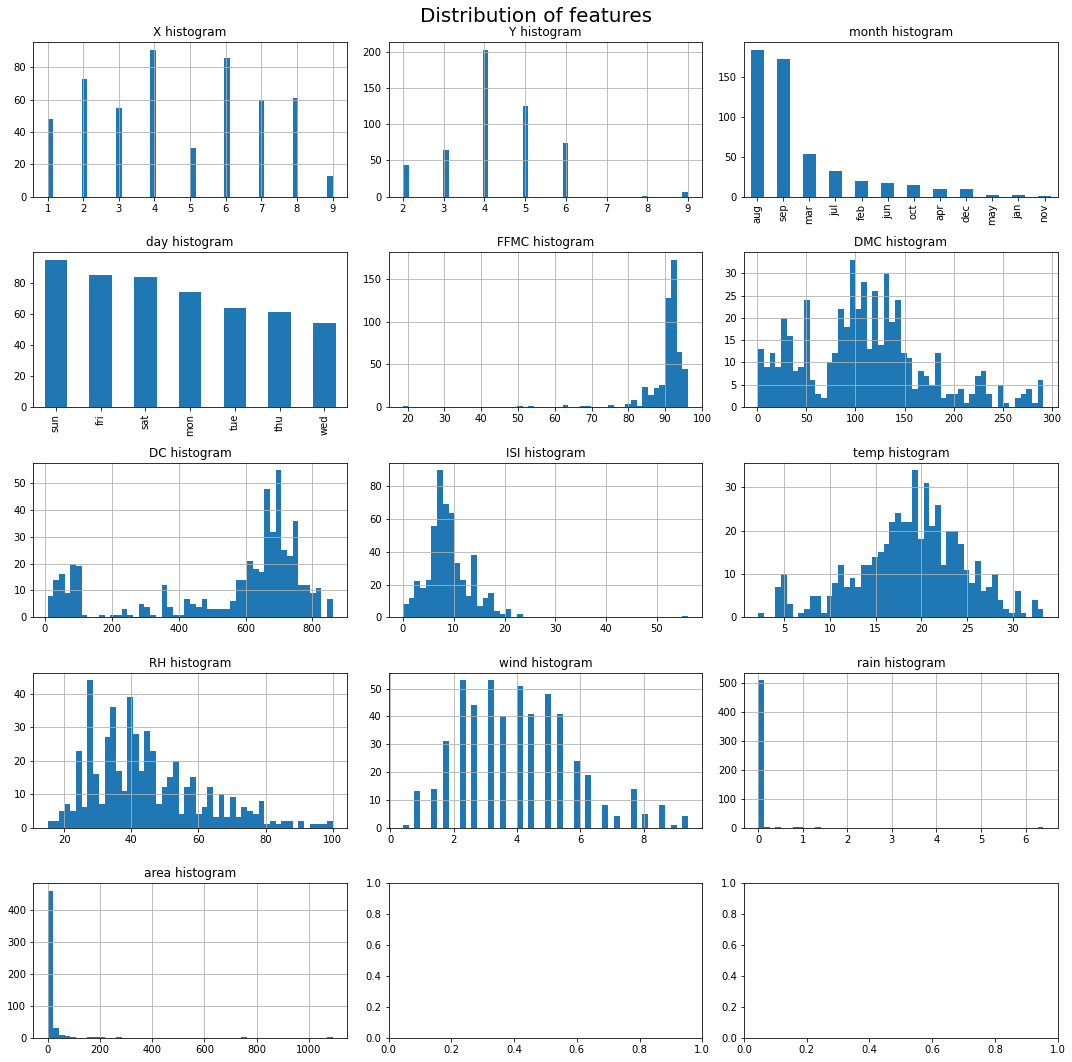

In [5]:
## Histograms of feature
def get_histogram(df,output):
    count=0
    for col in df.columns:
            count+=1
    if count%3==0:
        n_rows = count//3
    else:
        n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,15))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.subplot(n_rows,3,i+1)
            x=50
            df_new = df
            df_new[col].hist(bins=x)
            plt.title('{} histogram'.format(col))
            plt.suptitle('Distribution of features', fontsize=20)
            i+=1
        elif df[col].dtype == 'object':
#             col2=df[col].unique()
#             if(col=='month'):
#                 col2=sort_month(col2)
#             if(col=='day'):
#                 col2=sort_week(col2)
            plt.subplot(n_rows,3,i+1)
            df[col].value_counts().plot(kind='bar')
            plt.title('{} histogram'.format(col))
            i+=1
    plt.tight_layout()
    
display(get_histogram(df,'area'))

None

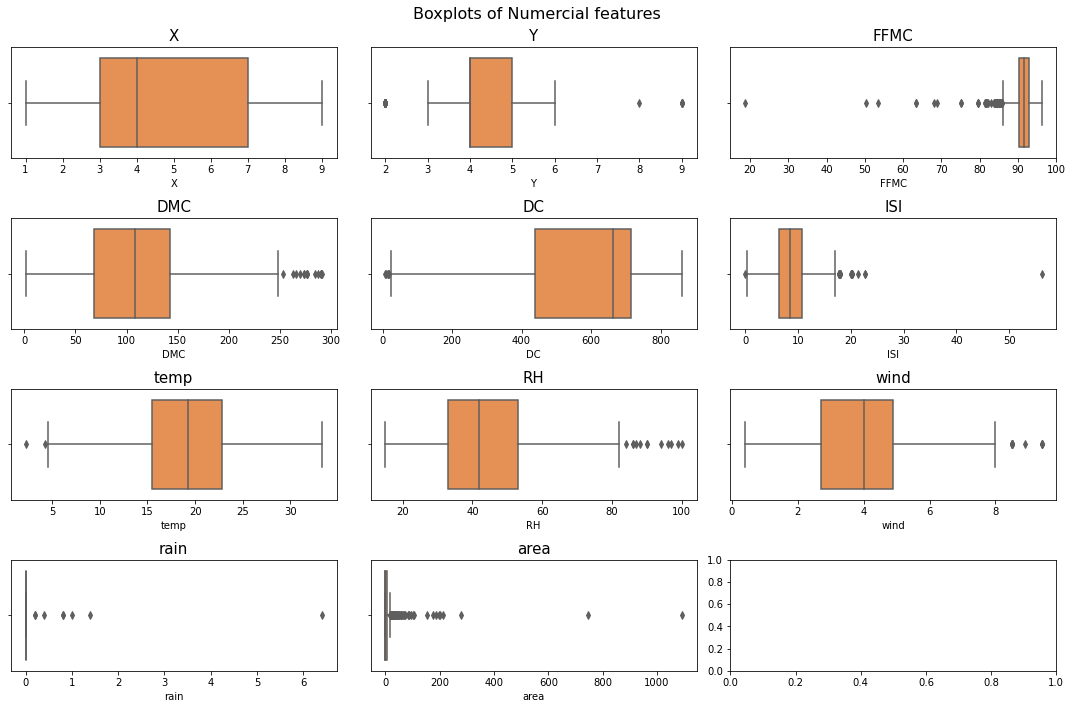

In [6]:
## Boxplots of numerical features
def boxplot_subplot(df):
    count=0
    for col in df.columns:
        if df[col].dtype!='object' and col!='Year':
            count+=1
        if count%3==0:
            n_rows = count//3
        else:
            n_rows=(count//3)+1
    plt.subplots(n_rows,3,figsize=(15,10))
    i=0
    fig=[]
    for col in df.columns:
        if df[col].dtype != 'object':
            fig.append(plt.subplot(n_rows,3,i+1))
            sns.boxplot(x=col,data=df,palette="Oranges_r",ax=fig[i]).set_title(col,fontsize=15)
            plt.suptitle('Boxplots of Numercial features', fontsize=16)
            plt.tight_layout()
            i+=1

display(boxplot_subplot(df))

<AxesSubplot:>

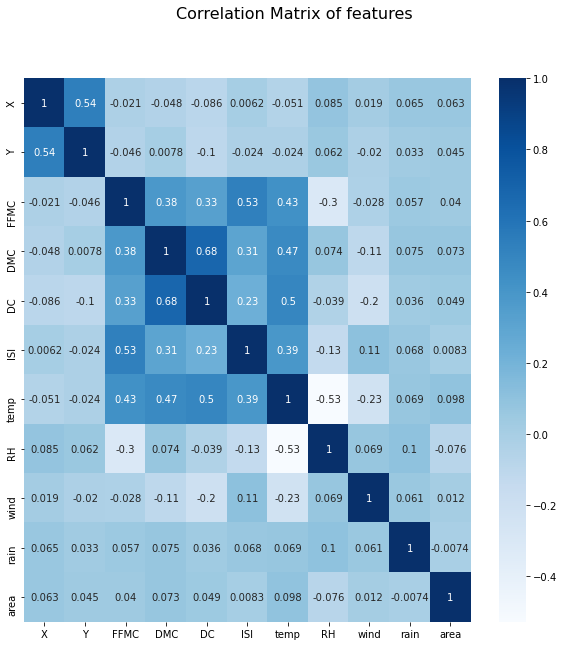

In [7]:
## Correlation matrix
plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1)
plt.suptitle('Correlation Matrix of features', fontsize=16)
corr = df.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [8]:
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [9]:
def pre_process(df, output):
    df = df.copy()
    
    # Ordinal encode month and day columns
    df = ordinal_encode(
        df,
        column='month',
        ordering=[
            'jan',
            'feb',
            'mar',
            'apr',
            'may',
            'jun',
            'jul',
            'aug',
            'sep',
            'oct',
            'nov',
            'dec'
        ]
    )
    df = ordinal_encode(
        df,
        column='day',
        ordering=[
            'sun',
            'mon',
            'tue',
            'wed',
            'thu',
            'fri',
            'sat'
        ]
    )
    
    # Split df into X and y
    y = df[output]
    
    X = df.drop('area', axis=1)
    
    return X, y

In [10]:
X,y=pre_process(df, 'area')
X

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,2,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,9,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,9,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,2,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,2,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,7,0,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,7,0,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,7,0,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,7,6,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
scaler = StandardScaler()
scaler.fit(X)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
y_train=pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.575701,0.569860,0.670325,-0.921154,0.046297,0.244241,0.559101,-0.443828,0.415588,-0.140366,-1.015466,-0.073268
1,-1.154748,-1.871724,-1.968443,-1.388053,-0.243833,-0.931043,-1.798600,0.126966,-2.308077,0.902471,1.275141,-0.073268
2,-0.289524,0.569860,0.230531,0.479542,-0.225700,2.427582,1.030400,-0.751178,-0.256709,0.595754,-0.512650,-0.073268
3,-0.289524,-0.244001,-1.968443,-0.454255,-0.461430,-1.331140,-1.938214,-1.146342,-0.825575,-0.079023,-0.736124,-0.073268
4,0.143088,-0.244001,0.230531,0.479542,0.753489,1.743042,0.607926,1.070970,0.243205,-0.140366,-0.736124,-0.073268
...,...,...,...,...,...,...,...,...,...,...,...,...
356,-1.154748,0.569860,1.110120,-1.388053,0.354560,-1.006061,0.580487,-0.048663,-0.601476,-0.569770,-1.741756,-0.073268
357,-1.154748,0.569860,0.230531,0.012643,0.880421,-0.171484,-0.139776,0.917295,0.846548,-0.753800,0.772325,-0.073268
358,0.143088,-0.244001,-1.968443,0.946441,0.191362,-1.212361,-1.898266,-0.004756,-0.567000,-1.183203,1.275141,-0.073268
359,1.440925,1.383722,0.230531,-1.388053,0.136963,0.492739,0.215716,0.346501,0.122536,-0.201709,0.995798,-0.073268


In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

def regression_fs():
    # create model
    model = Sequential()
    model.add(Dense(i+1, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(i+1, activation='relu'))
    model.add(Dense(i+1, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

columns = X_train.columns.to_list()
fws_col=[]
temp_r2=-1000;

for i in range(1,len(columns)+1):
    FW_NN = regression_fs()
    FW_NN2 = FW_NN.fit(X_train.iloc[:,0:i], y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=100)
    
    predict_y = FW_NN.predict(X_test.iloc[:,0:i])
    r2_fws=r2_score(y_test,predict_y)
    if(r2_fws>temp_r2):
        fws_col.append(columns[i-1])
        temp_r2=r2_fws;

In [13]:
# Columns selected in Forward selection
fws_col

['X', 'Y', 'temp', 'rain']

In [14]:
X_train = X_train[fws_col]
X_test = X_test[fws_col]

Building Neural nets with linear activation function


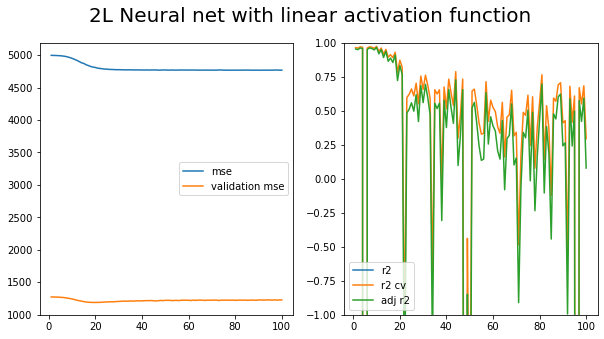

*******************************************************

Building Neural nets with relu activation function


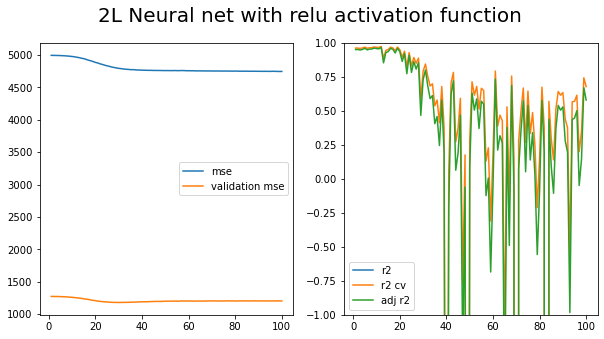

*******************************************************

Building Neural nets with sigmoid activation function


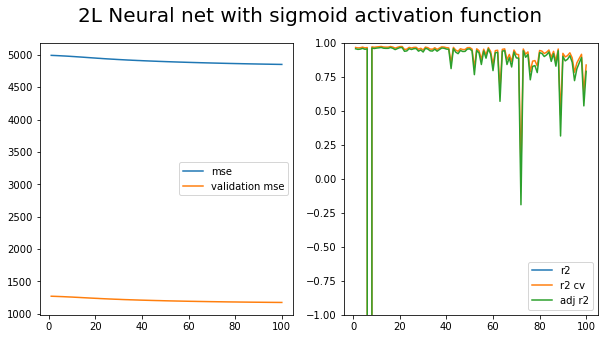

*******************************************************

Building Neural nets with tanh activation function


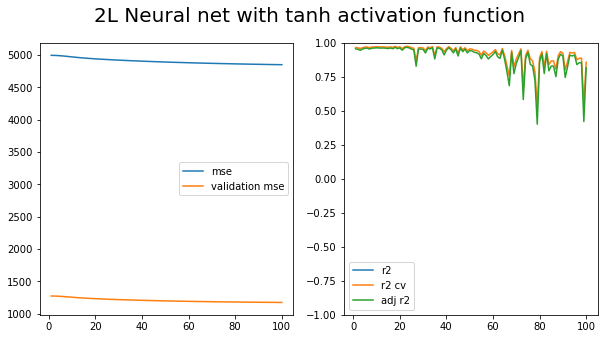

*******************************************************

Building Neural nets with elu activation function


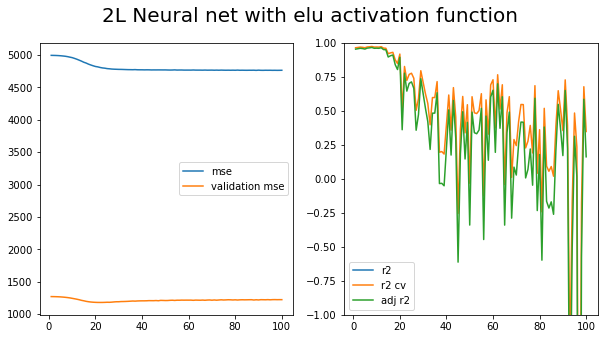

*******************************************************

Building Neural nets with softmax activation function


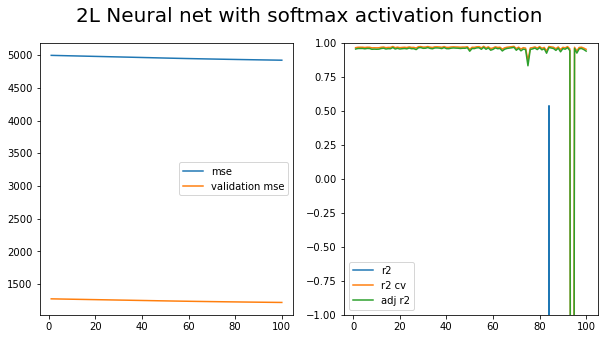

*******************************************************

Building Neural nets with softplus activation function


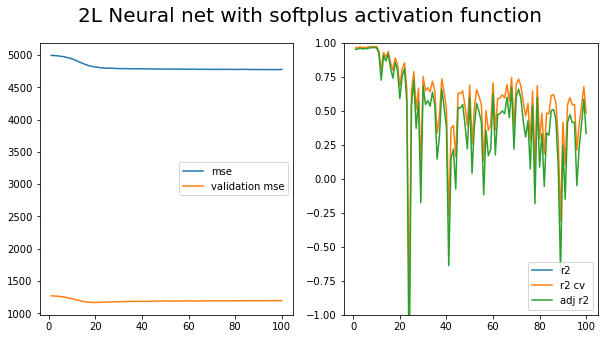

*******************************************************

Building Neural nets with softsign activation function


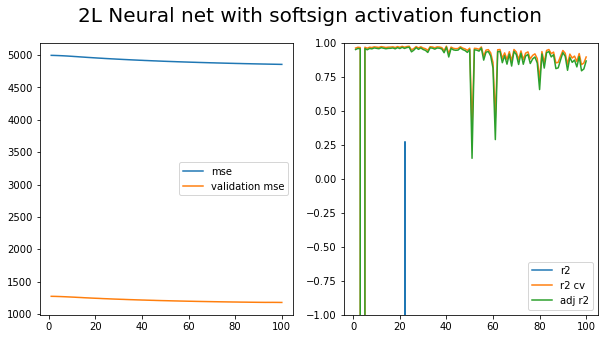

*******************************************************

Building Neural nets with selu activation function


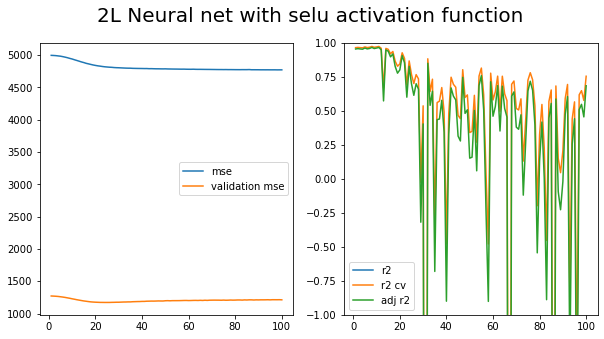

*******************************************************









In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

activation_list = ['linear','relu', 'sigmoid', 'tanh', 'elu','softmax','softplus','softsign','selu']
epoch_arr = [k for k in range(1,101)]

from keras import backend as K

def r2_coeff(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))
    

def adj_r2(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - (1 - r2_coeff(y_true, y_pred)) * (tf.cast(tf.size(y_true), tf.float32) - 1) / (tf.cast(tf.size(y_true), tf.float32) - tf.cast(tf.rank(y_true), tf.float32) - 1))

def regression(i):
    # create model
    model = Sequential()
    model.add(Dense(len(fws_col)+1, input_dim=len(fws_col), kernel_initializer='normal', activation=i))
    model.add(Dense(len(fws_col)+1, activation=i))
    model.add(Dense(len(fws_col)+1, activation=i))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse',r2_coeff, adj_r2])
    return model

r2_scores = []
adjusted_r2_scores = []
r2_scores_cv=[]
for i in activation_list:
    print("Building Neural nets with "+i+" activation function")
    Forest_fires_NN = regression(i)
    Forest_fires_NN_cv = regression(i)
    Forest_fires_NN2 = Forest_fires_NN.fit(X_train, y_train, batch_size=10,verbose=0,epochs=100)
    Forest_fires_NN_CV = Forest_fires_NN_cv.fit(X_train, y_train, batch_size=10,validation_split = 0.2, verbose=0,epochs=100)
    plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("XL Neural net with "+i+" activation function", fontsize=20)
    plt.subplot(121)
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['mse'],label="mse")
    plt.plot( epoch_arr,  Forest_fires_NN_CV.history['val_mse'],label="validation mse")
    plt.legend()
    plt.subplot(122)
    plt.plot( epoch_arr, Forest_fires_NN2.history['r2_coeff'],label="r2")
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['r2_coeff'],label="r2 cv")
    plt.plot( epoch_arr, Forest_fires_NN_CV.history['adj_r2'],label="adj r2")
    plt.ylim([-1, 1])
    plt.legend()
    plt.show()
    
    predict_y = Forest_fires_NN.predict(X_test)
    predict_y_cv = Forest_fires_NN_cv.predict(X_test)
    r2=r2_score(y_test,predict_y)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2_score(r2, X_train.shape[0],X_train.shape[1]-1))
    r2_scores_cv.append(r2_score(y_test,predict_y_cv))
#     Forest_fires_dict = Forest_fires_NN2.history
#     loss_values = Forest_fires_dict['loss']
#     val_loss_values = Forest_fires_dict['val_loss']
#     plt.figure()
#     plt.title('NN with '+i+' activation function')
#     plt.plot(loss_values, label="Training Loss")
#     plt.plot(val_loss_values, label="Validation Loss")
    
    print("*******************************************************\n")
print('\n')
print('\n')
print('\n')

In [17]:
print("************************* R2 scores of various activation functions *************************\n")
for i in range(len(activation_list)):
    print("R2 for NN using",activation_list[i],"activation is ",r2_scores[i]*100)
    print("Adj R2 for NN using",activation_list[i],"activation is ",adjusted_r2_scores[i]*100)
    print("R2 CV for NN using",activation_list[i],"activation is ",r2_scores_cv[i]*100)
    print('\n')
    

************************* R2 scores of various activation functions *************************

R2 for NN using linear activation is  -0.27382765692047784
Adj R2 for NN using linear activation is  -1.1164648641214914
R2 CV for NN using linear activation is  -0.15832803905586612


R2 for NN using relu activation is  3.1454178830827684
Adj R2 for NN using relu activation is  2.33151383168011
R2 CV for NN using relu activation is  3.6257828614105314


R2 for NN using sigmoid activation is  -0.5471635419606935
Adj R2 for NN using sigmoid activation is  -1.3920976893721404
R2 CV for NN using sigmoid activation is  -0.7895369669964403


R2 for NN using tanh activation is  -0.5990465129790845
Adj R2 for NN using tanh activation is  -1.4444166517436186
R2 CV for NN using tanh activation is  -0.7907190413529275


R2 for NN using elu activation is  2.1018323166064334
Adj R2 for NN using elu activation is  1.279158638594713
R2 CV for NN using elu activation is  2.89819639660015


R2 for NN using s

In [18]:
!jupyter nbconvert Project2_XL_NN(Forestfires).ipynb --to=pdf --TemplateExporter.exclude_input=True

[NbConvertApp] Converting notebook Project2_XL_NN(Forestfires).ipynb to pdf
[NbConvertApp] Writing 448798 bytes to Project2_XL_NN(Forestfires).pdf
